In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
import os

from stompy.grid import unstructured_grid
import stompy.model.data_comparison as dc

import stompy.model.delft.dflow_model as dfm
import pesca_base

INFO:DFlowModel:DelwaqScalarBC instantiated.


In [2]:
%matplotlib notebook

In [3]:
# Load the ESA dataset:
esa_waterlevel=xr.open_dataset("../calibration/esa_compiled_waterlevel.nc")

In [4]:
# Load BML dataset:
bml_data_dir="../../data/BML data/2016/all_concatenated"

# BC1 starts later.  All other sites okay for this period.
df=pd.read_csv(os.path.join(bml_data_dir,'csv','NCK_wll_concatenated.csv'))
# UTC
df['time']=pd.to_datetime( df[ ['year','month','day','hour','minute','second']])
nck_wll=df.set_index('time')
nck_wll.head()

INFO:numexpr.utils:Note: NumExpr detected 32 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


,year,month,day,hour,minute,second,depth m,temp degC,Unnamed: 8
time,,,,,,,,,
2016-04-06 23:24:00,2016,4,6,23,24,0,11.657694,13.846,NaN
2016-04-06 23:27:00,2016,4,6,23,27,0,11.656686,13.269,NaN
2016-04-06 23:30:00,2016,4,6,23,30,0,11.654668,12.980,NaN
2016-04-06 23:33:00,2016,4,6,23,33,0,11.652651,12.883,NaN
2016-04-06 23:36:00,2016,4,6,23,36,0,11.648617,12.787,NaN


In [21]:
# Earlier test overlapping with UCB period, and using ESA
# data
if 0:
    #model00=pesca_base.PescaButano.load("run_tide_test")
    model01=pesca_base.PescaButano.load('run_tide_test-v01')
    #model02=pesca_base.PescaButano.load('run_tide_test-v02')
    #model03=pesca_base.PescaButano.load('run_tide_test-v03')
    #model04=pesca_base.PescaButano.load('run_tide_test-v04')
    #model05=pesca_base.PescaButano.load('run_tide_test-v05')
    model06=pesca_base.PescaButano.load('run_tide_test-v06')
    observed=esa_waterlevel['waterlevel'].assign_coords(label="CTD")

In [22]:
# Updated test, using BML data
if 1:
    observed=xr.Dataset.from_dataframe(nck_wll)['depth m'].assign_coords(label='NCK wll')
    model07=pesca_base.PescaButano.load('run_salt_20160520-v00')
    model08=pesca_base.PescaButano.load('run_salt_20160520-v01')
    model09=pesca_base.PescaButano.load('run_salt_20160520-v02')    
    model=model07

In [31]:
model10=pesca_base.PescaButano.load('run_salt_20160520-v03')    


In [7]:
bcs=model07.load_bcs()

Not implemented: reading BC quantity=temperaturebnd
Not implemented: reading BC quantity=temperaturebnd
Not implemented: reading BC quantity=salinitybnd
Not implemented: reading BC quantity=temperaturebnd


In [8]:
ocean_bc=[bc for bc in bcs if bc['name']=='ocean_bc'][0]
ocean_bc

{'QUANTITY': 'waterlevelbnd',
 'FILENAME': 'ocean_bc.pli',
 'FILETYPE': '9',
 'METHOD': '3',
 'OPERAND': 'O',
 'name': 'ocean_bc',
 'pli': [('ocean_bc',
   array([[ 552081.42284061, 4124663.59300452],
          [ 552127.64909061, 4124668.95855139]]),
   ['', ''])],
 'coordinates': array([[ 552081.42284061, 4124663.59300452],
        [ 552127.64909061, 4124668.95855139]]),
 'geom': <shapely.geometry.linestring.LineString at 0x7f9b52598a00>,
 'data': <xarray.Dataset>
 Dimensions:  (node: 1, time: 7443)
 Coordinates:
   * time     (time) datetime64[ns] 2016-05-19T23:54:00 ... 2016-06-20T00:06:00
 Dimensions without coordinates: node
 Data variables:
     stage    (node, time) float64 0.715 0.717 0.74 0.8 ... 0.865 0.875 0.894
     x        (node) float64 5.521e+05
     y        (node) float64 4.125e+06
 Attributes:
     source:   run_salt_20160520-v00/ocean_bc_0001.tim,
 'bc': <stompy.model.hydro_model.StageBC at 0x7f9b52567670>}

In [13]:
from stompy.io.local import noaa_coops

mb_gauge=noaa_coops.coops_dataset_product(station=9413450,
                                          product='water_level',
                                          start_date=model.run_start,
                                          end_date=model.run_stop,
                                          cache_dir='cache')

an_gauge=noaa_coops.coops_dataset_product(station=9413878,
                                          product='predictions',
                                          interval='hilo',
                                          start_date=model.run_start,
                                          end_date=model.run_stop,
                                          cache_dir='cache')

INFO:noaa_coops:Cached   2016-05-01 00:00:00 -- 2016-06-01 00:00:00
INFO:noaa_coops:Cached   2016-06-01 00:00:00 -- 2016-07-01 00:00:00
INFO:noaa_coops:Cached   2016-05-01 00:00:00 -- 2016-06-01 00:00:00
INFO:noaa_coops:Fetching 2016-05-01 00:00:00 -- 2016-06-01 00:00:00
INFO:noaa_coops:Cached   2016-06-01 00:00:00 -- 2016-07-01 00:00:00


<IPython.core.display.Javascript object>


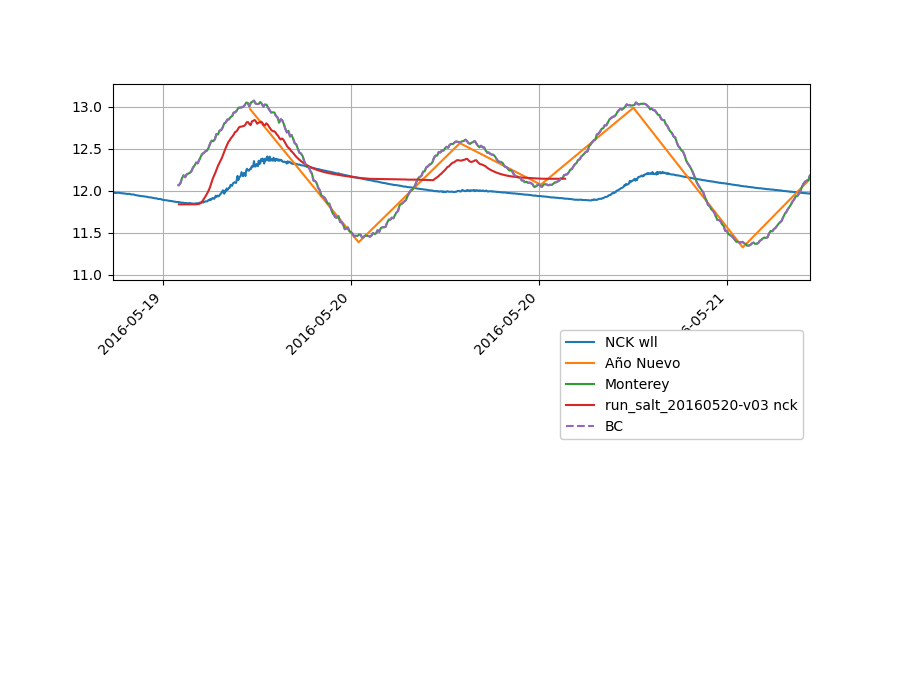

In [32]:
import six
six.moves.reload_module(dc)

sources=[observed]

sources.append( an_gauge.predictions.isel(station=0).assign_coords(label='Año Nuevo') )
sources.append( mb_gauge.water_level.isel(station=0).assign_coords(label='Monterey'))

for model in [model10]:
    his_ds=xr.open_dataset(model.his_output())

    for model_stn in [ b'nck' ]:
        sel=np.nonzero( his_ds['station_name'].values==model_stn )[0][0]
        predicted=his_ds['waterlevel'].isel(stations=sel)
        predicted=predicted.assign_coords(label=f'{model.run_dir} {model_stn.decode()}')
        sources.append(predicted)
    
    his_ds.close()

sources.append( ocean_bc['data']['stage'].isel(node=0).assign_coords(label='BC'))

# sources[1]['label']=(),'Open mouth, no constriction'
# sources[2]['label']=(),'Open mouth, partial constriction'
fig=dc.calibration_figure_3panel(sources,trim_time=False,lowpass=False,metric_x=None)
fig.axes[2].set_visible(0)
fig.axes[1].set_visible(0)

ax=fig.axes[0]
ax.axis([16957.813032803748, 16958.72289133207, 
                  10.497886219416628, 13.38061368842699])

if 0:
    from matplotlib.ticker import FuncFormatter
    import matplotlib.dates as mdates

    hours = mdates.HourLocator(interval = 1)
    h_fmt = mdates.DateFormatter('%H:%M')
    ax.xaxis.set_major_locator(hours)
    ax.xaxis.set_major_formatter(h_fmt)
    
plt.setp(ax.get_xticklabels(),rotation=45,ha='right')
ax.grid(1)

ax.lines[4].set_linestyle('--')

ax.legend(loc='upper right',bbox_to_anchor=[1.0,-0.22],
          framealpha=1.0)

In [20]:
model08.run_start, model08.run_stop # 2016-05-20 through 2016-06-20
#  

(numpy.datetime64('2016-05-20T00:00:00.000000'),
 numpy.datetime64('2016-06-20T00:00:00.000000'))

In [95]:
fig.savefig('manytides.png',dpi=200)

In [37]:
fns=model10.map_outputs()

In [39]:
ds=xr.open_dataset(fns[0])

In [40]:
ds

<xarray.Dataset>
Dimensions:                      (laydim: 10, nBndLink: 235, nFlowElem: 5366, nFlowElemContourPts: 4, nFlowLink: 8392, nFlowLinkPts: 2, nNetElem: 5366, nNetElemMaxNode: 4, nNetLink: 8627, nNetLinkContourPts: 4, nNetLinkPts: 2, nNetNode: 3262, nmesh2d_EnclosureInstance: 1, nmesh2d_EnclosureParts: 1, nmesh2d_EnclosurePoints: 188, time: 6, wdim: 11)
Coordinates:
    NetNode_x                    (nNetNode) float64 ...
    NetNode_y                    (nNetNode) float64 ...
    FlowElem_xcc                 (nFlowElem) float64 ...
    FlowElem_ycc                 (nFlowElem) float64 ...
    FlowLink_xu                  (nFlowLink) float64 ...
    FlowLink_yu                  (nFlowLink) float64 ...
  * time                         (time) datetime64[ns] 2016-05-20 ... 2016-05...
Dimensions without coordinates: laydim, nBndLink, nFlowElem, nFlowElemContourPts, nFlowLink, nFlowLinkPts, nNetElem, nNetElemMaxNode, nNetLink, nNetLinkContourPts, nNetLinkPts, nNetNode, nmesh2d_EnclosureInstance, nmesh2d_EnclosureParts, nmesh2d_EnclosurePoints, wdim
Data variables:
    mesh2d_enc_x                 (nmesh2d_EnclosurePoints) float64 ...
    mesh2d_enc_y                 (nmesh2d_EnclosurePoints) float64 ...
    mesh2d_enc_node_count        (nmesh2d_EnclosureInstance) int32 ...
    mesh2d_enc_part_node_count   (nmesh2d_EnclosureParts) int32 ...
    mesh2d_enc_interior_ring     (nmesh2d_EnclosureParts) int32 ...
    mesh2d_enclosure_container   float32 ...
    Mesh2D                       int32 ...
    projected_coordinate_system  int32 ...
    NetNode_z                    (nNetNode) float64 ...
    NetLink                      (nNetLink, nNetLinkPts) int32 ...
    NetLinkType                  (nNetLink) int32 ...
    NetElemNode                  (nNetElem, nNetElemMaxNode) float64 ...
    NetElemLink                  (nNetElem, nNetElemMaxNode) int32 ...
    NetLinkContour_x             (nNetLink, nNetLinkContourPts) float64 ...
    NetLinkContour_y             (nNetLink, nNetLinkContourPts) float64 ...
    NetLink_xu                   (nNetLink) float64 ...
    NetLink_yu                   (nNetLink) float64 ...
    BndLink                      (nBndLink) int32 ...
    FlowElem_zcc                 (nFlowElem) float64 ...
    FlowElem_bac                 (nFlowElem) float64 ...
    FlowElem_xzw                 (nFlowElem) float64 ...
    FlowElem_yzw                 (nFlowElem) float64 ...
    FlowElemContour_x            (nFlowElem, nFlowElemContourPts) float64 ...
    FlowElemContour_y            (nFlowElem, nFlowElemContourPts) float64 ...
    FlowElem_bl                  (nFlowElem) float64 ...
    ElemLink                     (nNetLink, nNetLinkPts) int32 ...
    FlowLink                     (nFlowLink, nFlowLinkPts) int32 ...
    FlowLinkType                 (nFlowLink) int32 ...
    FlowLink_lonu                (nFlowLink) float64 ...
    FlowLink_latu                (nFlowLink) float64 ...
    FlowElemDomain               (nFlowElem) int32 ...
    FlowLinkDomain               (nFlowLink) int32 ...
    FlowElemGlobalNr             (nFlowElem) int32 ...
    LayCoord_cc                  (laydim) float64 ...
    LayCoord_w                   (wdim) float64 ...
    timestep                     (time) timedelta64[ns] ...
    s1                           (time, nFlowElem) float64 ...
    s0                           (time, nFlowElem) float64 ...
    waterdepth                   (time, nFlowElem) float64 ...
    numlimdt                     (time, nFlowElem) float64 ...
    taus                         (time, nFlowElem) float64 ...
    unorm                        (time, nFlowLink, laydim) float64 ...
    u0                           (time, nFlowLink, laydim) float64 ...
    q1                           (time, nFlowLink, laydim) float64 ...
    viu                          (time, nFlowLink, laydim) float64 ...
    diu                          (time, nFlowLink, laydim) float64 ...
    ucz                          (time, nFlowElem,

In [47]:
for fn in model10.map_outputs():
    ds=xr.open_dataset(fn)
    rho_last=ds.rho.isel(time=-1).values
    print(fn)
    print(np.all( np.isnan(rho_last), axis=0))

run_salt_20160520-v03/DFM_OUTPUT_flowfm/flowfm_0000_map.nc
[ True  True  True  True  True  True False False False False]
run_salt_20160520-v03/DFM_OUTPUT_flowfm/flowfm_0001_map.nc
[ True  True  True  True  True  True  True False False False]
run_salt_20160520-v03/DFM_OUTPUT_flowfm/flowfm_0002_map.nc
[ True  True  True  True  True  True  True  True  True False]
run_salt_20160520-v03/DFM_OUTPUT_flowfm/flowfm_0003_map.nc
[ True  True  True  True  True  True  True  True  True False]
run_salt_20160520-v03/DFM_OUTPUT_flowfm/flowfm_0004_map.nc
[ True  True  True  True  True  True  True  True False False]
run_salt_20160520-v03/DFM_OUTPUT_flowfm/flowfm_0005_map.nc
[ True  True  True  True  True  True  True  True  True False]
run_salt_20160520-v03/DFM_OUTPUT_flowfm/flowfm_0006_map.nc
[ True  True  True  True  True  True  True  True  True False]
run_salt_20160520-v03/DFM_OUTPUT_flowfm/flowfm_0007_map.nc
[ True  True  True  True  True  True  True  True  True False]
run_salt_20160520-v03/DFM_OUTPUT

In [ ]:
# so domains 10,14 have all layers

In [111]:
ds=xr.open_dataset('run_salt_20160520-v03/DFM_OUTPUT_flowfm/flowfm_0014_map.nc')

In [129]:
# Where is the hole coming from in the Delta marsh?
ds_inp=xr.open_dataset('../grids/pesca_butano_v00/pesca_butano_v00_existing_bathy.nc')
g=unstructured_grid.UnstructuredGrid.read_ugrid(ds_inp)

<IPython.core.display.Javascript object>


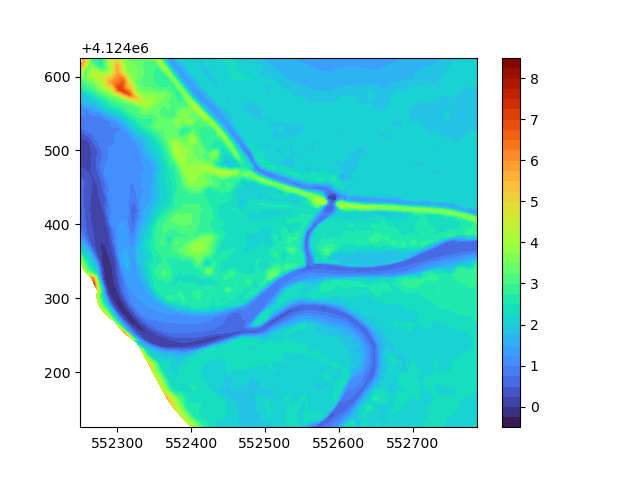

(552074.5882226144, 554067.0662501348, 4122750.3243895927, 4125365.499854582)

In [60]:
plt.figure()
cset=g.contourf_node_values(g.nodes['node_z_bed'],40,cmap='turbo')
plt.colorbar(cset)
plt.axis('equal')

In [112]:
ds.NetNode_z.values.max()

4.2563154328773045

In [113]:
nlay=np.sum(np.isfinite(ds.sa1.isel(time=-1).values),axis=1)

In [114]:
g14=unstructured_grid.UnstructuredGrid.read_ugrid(ds)

<IPython.core.display.Javascript object>


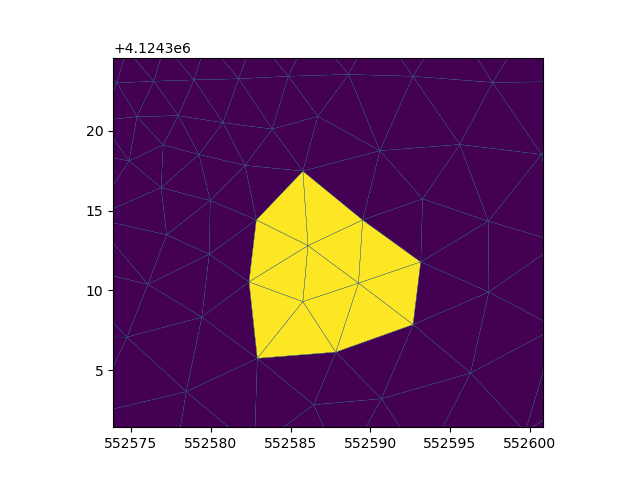

In [115]:
plt.figure()
g14.plot_edges(color='k',lw=0.2)
g14.plot_cells(values=nlay)
g.plot_edges(color='tab:blue',lw=0.2)

In [116]:
pnt=[552586,4124311]
c=g14.select_cells_nearest(pnt)
c

664

In [120]:
# Appears to have a bed elevation of -1m? that's the lowest in the domain.
# temp=18, salt=0 for all layers.
ds.isel(nFlowElem=664,time=-1)

<xarray.Dataset>
Dimensions:                      (laydim: 10, nBndLink: 274, nFlowElemContourPts: 4, nFlowLink: 8709, nFlowLinkPts: 2, nNetElem: 5461, nNetElemMaxNode: 4, nNetLink: 8983, nNetLinkContourPts: 4, nNetLinkPts: 2, nNetNode: 3523, nmesh2d_EnclosureInstance: 1, nmesh2d_EnclosureParts: 1, nmesh2d_EnclosurePoints: 227, wdim: 11)
Coordinates:
    NetNode_x                    (nNetNode) float64 5.53e+05 ... 5.526e+05
    NetNode_y                    (nNetNode) float64 4.125e+06 ... 4.124e+06
    FlowElem_xcc                 float64 ...
    FlowElem_ycc                 float64 ...
    FlowLink_xu                  (nFlowLink) float64 5.525e+05 ... 5.53e+05
    FlowLink_yu                  (nFlowLink) float64 4.124e+06 ... 4.125e+06
    time                         datetime64[ns] 2016-05-21T06:00:00
Dimensions without coordinates: laydim, nBndLink, nFlowElemContourPts, nFlowLink, nFlowLinkPts, nNetElem, nNetElemMaxNode, nNetLink, nNetLinkContourPts, nNetLinkPts, nNetNode, nmesh2d_EnclosureInstance, nmesh2d_EnclosureParts, nmesh2d_EnclosurePoints, wdim
Data variables:
    mesh2d_enc_x                 (nmesh2d_EnclosurePoints) float64 5.525e+05 ...
    mesh2d_enc_y                 (nmesh2d_EnclosurePoints) float64 4.124e+06 ...
    mesh2d_enc_node_count        (nmesh2d_EnclosureInstance) int32 227
    mesh2d_enc_part_node_count   (nmesh2d_EnclosureParts) int32 227
    mesh2d_enc_interior_ring     (nmesh2d_EnclosureParts) int32 0
    mesh2d_enclosure_container   float32 9.969e+36
    Mesh2D                       int32 -2147483647
    projected_coordinate_system  int32 -2147483647
    NetNode_z                    (nNetNode) float64 2.185 2.236 ... 2.318 2.363
    NetLink                      (nNetLink, nNetLinkPts) int32 1040 1041 ... 56
    NetLinkType                  (nNetLink) int32 2 2 2 2 2 2 2 ... 2 2 2 2 2 2
    NetElemNode                  (nNetElem, nNetElemMaxNode) float64 1.04e+03...
    NetElemLink                  (nNetElem, nNetElemMaxNode) int32 1 3 ... 8981
    NetLinkContour_x             (nNetLink, nNetLinkContourPts) float64 5.525...
    NetLinkContour_y             (nNetLink, nNetLinkContourPts) float64 4.124...
    NetLink_xu                   (nNetLink) float64 5.525e+05 ... 5.53e+05
    NetLink_yu                   (nNetLink) float64 4.124e+06 ... 4.125e+06
    BndLink                      (nBndLink) int32 1 4 7 8 ... 8977 8980 8981
    FlowElem_zcc                 float64 ...
    FlowElem_bac                 float64 ...
    FlowElem_xzw                 float64 ...
    FlowElem_yzw                 float64 ...
    FlowElemContour_x            (nFlowElemContourPts) float64 ...
    FlowElemContour_y            (nFlowElemContourPts) float64 ...
    FlowElem_bl                  float64 ...
    ElemLink                     (nNetLink, nNetLinkPts) int32 1 0 ... 5461 5460
    FlowLink                     (nFlowLink, nFlowLinkPts) int32 1 4 ... 5460
    FlowLinkType                 (nFlowLink) int32 2 2 2 2 2 2 2 ... 2 2 2 2 2 2
    FlowLink_lonu                (nFlowLink) float64 9.969e+36 ... 9.969e+36
    FlowLink_latu                (nFlowLink) float64 9.969e+36 ... 9.969e+36
    FlowElemDomain               int32 ...
    FlowLinkDomain               (nFlowLink) int32 14 14 14 14 ... 14 14 14 14
    FlowElemGlobalNr             int32 ...
    LayCoord_cc                  (laydim) float64 9.969e+36 ... 9.969e+36
    LayCoord_w                   (wdim) float64 9.969e+36 ... 9.969e+36
    timestep                     timedelta64[ns] 00:00:00.335649340
    s1                           float64 ...
    s0                           float64 ...
    waterdepth                   float64 ...
    numlimdt                     float64 ...
    taus                         float64 ...
    unorm                        (nFlowLink, laydim) float64 ...
    u0                           (nFlowLink, laydim) float64 ...
    q1                           (nFlowLink, laydim) float64 ...
    viu                          (nFlowLink, layd

In [122]:
ds.FlowElem_bl.min()

<xarray.DataArray 'FlowElem_bl' ()>
array(-1.)

In [89]:
ds.FlowElem_zcc.values.min(), ds.FlowElem_zcc.values.max() # -3.8, 1

(-3.805044878800278, 1.0)

In [91]:
ds.FlowElem_bl.values.min(), ds.FlowElem_bl.values.max() # -1, 3.8

(-1.0, 3.805044878800278)

In [96]:
his_ds=xr.open_dataset(model10.his_output())

In [100]:
# The history file has actual z coordinate information
# Only ranges from -0.227 to 1.4
his_ds.zcoordinate_c.values.min() , his_ds.zcoordinate_c.values.max()

(-0.22735000000000002, 1.369157647737335)

In [110]:

for stn in range(his_ds.dims['stations']):
    print(stn)
    print(f"  bl: {his_ds.bedlevel.isel(stations=stn).values:.4f}")
    z_w=his_ds.zcoordinate_w.isel(stations=stn).values
    print(f"  z_w: {z_w.min():.4f} {z_w.max():.4f}")
    z_c=his_ds.zcoordinate_c.isel(stations=stn).values
    print(f"  z_c: {z_c.min():.4f} {z_c.max():.4f}")

0
  bl: 0.7644
  z_w: 0.0000 1.6738
  z_c: 0.6548 1.1096
1
  bl: 0.4714
  z_w: 0.0000 1.7146
  z_c: 0.4595 1.1300
2
  bl: -0.2377
  z_w: -0.3132 1.7217
  z_c: -0.2274 1.1335
3
  bl: 1.0902
  z_w: 0.0000 1.2886
  z_c: 0.8177 0.9169
4
  bl: 1.1261
  z_w: 0.0000 1.7424
  z_c: 0.8357 1.1439
5
  bl: 0.8789
  z_w: 0.0000 1.7061
  z_c: 0.7121 1.1257
6
  bl: 0.6000
  z_w: 0.0000 1.7121
  z_c: 0.6311 1.1287
7
  bl: 0.1277
  z_w: 0.0000 1.7218
  z_c: 0.1161 1.1336
8
  bl: 0.4145
  z_w: 0.0000 1.7221
  z_c: 0.4595 1.1337
9
  bl: 2.1930
  z_w: 0.0000 2.1930
  z_c: 1.3692 1.3692
10
  bl: 0.4239
  z_w: 0.0000 1.7177
  z_c: 0.4595 1.1315
11
  bl: 1.4015
  z_w: 0.0000 1.4015
  z_c: 0.9734 0.9734
12
  bl: 1.2282
  z_w: 0.0000 1.2886
  z_c: 0.8867 0.9169
13
  bl: 0.2681
  z_w: 0.0000 1.7161
  z_c: 0.2878 1.1307
14
  bl: 0.2848
  z_w: 0.0000 1.7161
  z_c: 0.2878 1.1307


In [123]:
# Checking on files generated by DFM
# Nothing of much use here.  maybe the "official" domain for each cell?

ds_i=xr.open_dataset("run_salt_20160520-v03/DFM_interpreted_idomain_pesca_butano_v00_existing_bathy_net.nc")

In [127]:
ds_i.NetNode_z.min() # -1 minimum.

g_int=unstructured_grid.UnstructuredGrid.read_ugrid(ds_i)

<IPython.core.display.Javascript object>


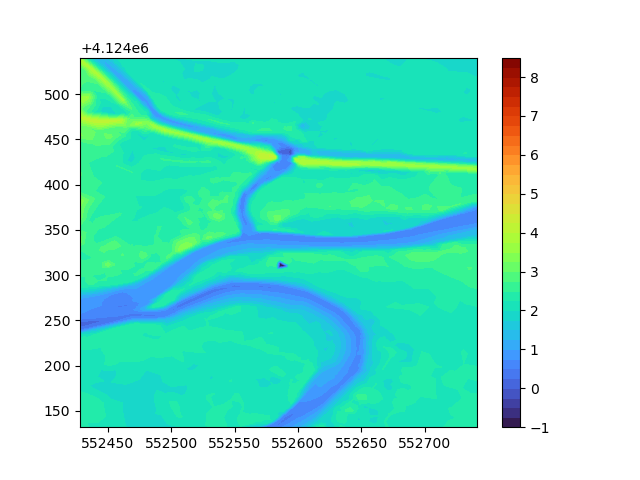

In [128]:
plt.figure()
cset=g_int.contourf_node_values(ds_i.NetNode_z.values,40,cmap='turbo')
plt.colorbar(cset)

<IPython.core.display.Javascript object>


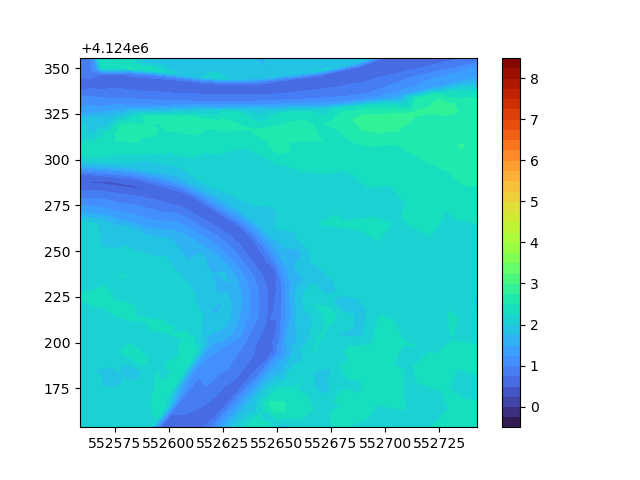

In [132]:
# Presumably what I'm feeding in:
# This does not have the weird low spot.
plt.figure()
g_inp=unstructured_grid.UnstructuredGrid.read_ugrid(ds_inp)
cset=g_int.contourf_node_values(ds_inp.node_z_bed.values,40,cmap='turbo')
plt.colorbar(cset)



In [133]:
# The net file supplied to DFM:
ds_net=xr.open_dataset("run_salt_20160520-v03/pesca_butano_v00_existing_bathy_net.nc")

In [136]:
ds_net.NetNode_z.min() # This does have a -1.

<xarray.DataArray 'NetNode_z' ()>
array(-1.)

<IPython.core.display.Javascript object>


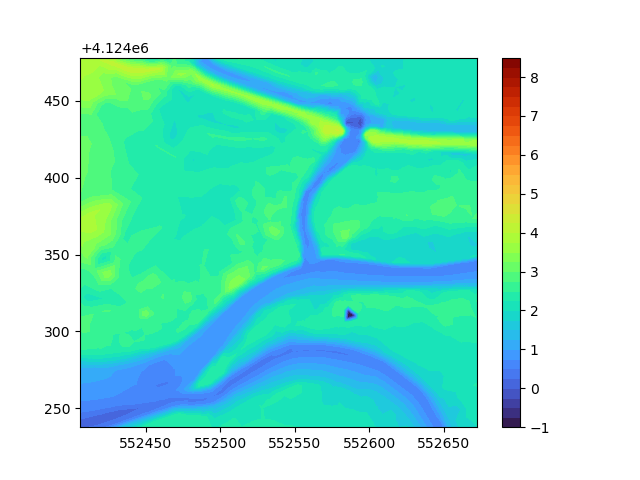

In [138]:
g_net=unstructured_grid.UnstructuredGrid.read_dfm(ds_net)
plt.figure()
cset=g_net.contourf_node_values(ds_net.NetNode_z.values,40,cmap='turbo')
plt.colorbar(cset)

<IPython.core.display.Javascript object>


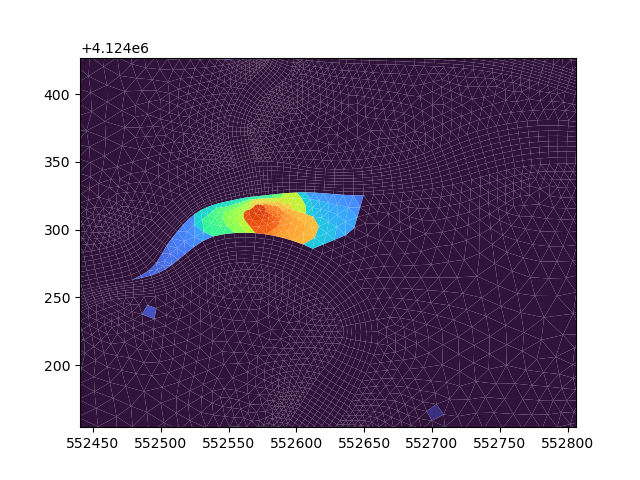

(551974.9643212383, 554166.6901515109, 4122619.5656163436, 4125496.2586278315)

In [142]:
# So this is probably related to dredging boundaries??
# yeah, this is the last cell.
plt.figure()
ccoll=g_net.plot_cells(values=np.arange(g_net.Ncells()),cmap='turbo')
plt.axis('tight')
plt.axis('equal')

In [145]:
ccoll.set_clim([71000,71450])